In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import PIL.Image
from os.path import isfile, join, exists
from os import listdir
from sklearn import preprocessing
from random import randint

In [2]:
test_image = PIL.Image.open(open('captcha/images/0_4test.png',"rb")).convert('L')

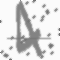

In [3]:
test_image

In [4]:
test_image_arr = np.asarray(test_image,dtype='int32')
print(test_image_arr.shape)
print(test_image_arr)

(60, 60)


In [5]:
image_base_path = 'captcha/images'
test_image_path = 'test'
train_image_path = 'train'
validate_image_path = 'validate'
image_extension = 'png'

In [6]:
def one_hot_encoding(data):
    lb = preprocessing.LabelBinarizer()
    lb.fit([0,1,2,3,4,5,6,7,8,9])
    return lb.transform(data)


In [7]:
#test one hot encoding
one_hot_encoding([2,3,4])

array([[0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]])

In [8]:
def image_to_array(complete_path):
    img = PIL.Image.open(open(complete_path,"rb")).convert('L')
    mat = np.asarray(img,dtype="int32")
    return mat.flatten()
    

In [9]:
def create_image_path(base,specific,file_name,extension):
    return base + '/'+specific+'/'+file_name

In [10]:
def create_directory_path(base,specific):
    return base + '/'+specific

In [11]:
def extract_label_from_filename(file_name):
    return int(file_name.split('_')[1].split('.')[0])

In [12]:
def read_all_files_from_directory(specific):
    
    directory = create_directory_path(base=image_base_path,specific=specific)
    if exists(directory):
        onlyfiles = [f for f in listdir(directory) if isfile(join(directory, f))]
        onlyfiles.remove('.DS_Store')
        return onlyfiles
    return None

In [13]:
def load_data(specific):


    onlyfiles = read_all_files_from_directory(specific=specific)
    input_arr = np.empty((len(onlyfiles),3600,),int)
    label_arr = np.empty((len(onlyfiles)), dtype=int)
    if onlyfiles is not None:
        for i in range(len(onlyfiles)):
            if 'png' in onlyfiles[i]:
                temp_input = image_to_array(create_image_path(image_base_path,specific,onlyfiles[i],image_extension))
                temp_label = extract_label_from_filename(onlyfiles[i])
                input_arr[i] = temp_input
                label_arr[i] = temp_label
    return input_arr,label_arr            
                

Below step is quite slow for not , it will take atleas 5 mins

In [14]:
train_input , train_label =  load_data(train_image_path)
print('training data loaded')
validate_input,validate_label = load_data(validate_image_path)
print('validating data loaded')
test_input , test_label = load_data(test_image_path)
print('test data loaded')

training data loaded
validating data loaded
test data loaded


In [15]:
train_label_en = one_hot_encoding(train_label)
validate_label_en = one_hot_encoding(validate_label)
test_label_en = one_hot_encoding(test_label)

In [16]:
print('input data shape',train_input.shape,train_input[0].shape)
print('label data shape',train_label.shape,train_label[0].shape)
print(train_input[3])
print(train_label[3])
print(train_label_en[3])

input data shape (8000, 3600) (3600,)
label data shape (8000,) ()
[248 248 248 ..., 248 248 248]
6
[0 0 0 0 0 0 1 0 0 0]


In [17]:
filter_size_1 = 11
filter_num_1 = 16

filter_size_2 = 11
filter_num_2 = 36

fc_size_0 = 4000
fc_size_1 = 2000
fc_size_2 = 1000
fc_size_3 = 200

In [18]:
img_size = 60
num_channels = 1
img_size_flat = img_size * img_size
img_shape = (img_size, img_size,)
num_classes = 10

In [19]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.6, wspace=0.6)
    
    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

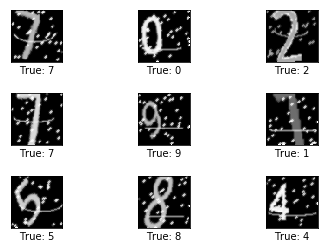

In [20]:

images = test_input[0:9]

cls_true = test_label[0:9]

plot_images(images=images, cls_true=cls_true)

In [21]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [22]:
def new_biases(length):
    #equivalent to y intercept
    #constant value carried over across matrix math
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [23]:
def new_con_layer(input,number_input_channel,filter_size,number_of_filters,use_pooling= True):
    
    shape = [filter_size, filter_size, number_input_channel, number_of_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=number_of_filters)
    layer = tf.nn.conv2d(input=input,filter=weights,strides=[1,2,2,1],padding='SAME')
    
    if use_pooling:
        layer = tf.nn.max_pool(layer,strides=[1,2,2,1],ksize=[1,2,2,1],padding='SAME')
        
    layer = tf.nn.relu(layer)
    return layer,weights


In [24]:
def flatten_layer(input):
    input_shape = input.shape
    num_features = input_shape[1:4].num_elements()
    layer_flat = tf.reshape(input, [-1, num_features])
    return layer_flat,num_features


In [25]:
def fully_connected_layer(input,num_of_input,num_of_output,use_relu =True):
    
    weights = new_weights(shape=[num_of_input, num_of_output])
    biases = new_biases(length=num_of_output)
    layer = tf.matmul(input,weights)+biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer

In [26]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)


In [27]:
layer_conv1, weights_conv1 = \
    new_con_layer(input=x_image,
                   number_input_channel=num_channels,
                   filter_size=filter_size_1,
                   number_of_filters=filter_num_1,
                   use_pooling=True)
print(layer_conv1)    

Tensor("Relu:0", shape=(?, 15, 15, 16), dtype=float32)


In [28]:
layer_conv2, weights_conv2 = \
    new_con_layer(input=layer_conv1,
                   number_input_channel=filter_num_1,
                   filter_size=filter_size_2,
                   number_of_filters=filter_num_2,
                   use_pooling=True)
print(layer_conv2)    

Tensor("Relu_1:0", shape=(?, 4, 4, 36), dtype=float32)


In [29]:
layer_flatten,number_of_features = flatten_layer(layer_conv2)
print(layer_flatten)
print(number_of_features)


Tensor("Reshape_1:0", shape=(?, 576), dtype=float32)
576


In [30]:
layer_fc1 = fully_connected_layer(layer_flatten,number_of_features,fc_size_3)
print(layer_fc1)
# layer_fc2 = fully_connected_layer(layer_fc1,fc_size_0,fc_size_1)
# print(layer_fc2)
# layer_fc3 = fully_connected_layer(layer_fc2,fc_size_1,fc_size_2)
# print(layer_fc3)
# layer_fc4 = fully_connected_layer(layer_fc3,fc_size_2,fc_size_3)
# print(layer_fc4)


Tensor("Relu_2:0", shape=(?, 200), dtype=float32)


In [31]:
layer_fc5 = fully_connected_layer(layer_fc1,fc_size_3,num_classes,use_relu=False)
print(layer_fc5)

Tensor("add_1:0", shape=(?, 10), dtype=float32)


In [64]:
y_pred = tf.nn.softmax(layer_fc5)
y_pred_cls = tf.argmax(y_pred, dimension=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc5,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(cost)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [65]:

session = tf.Session()
session.run(tf.global_variables_initializer())
train_batch_size = 128


In [66]:
def getBatch(data,label,batch_size):
    data_size = len(data)
    lower_limit = randint(0,data_size-batch_size)
    return data[lower_limit:lower_limit+batch_size],label[lower_limit:lower_limit+batch_size]
    

In [67]:
total_iterations = 0
def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,total_iterations+num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = getBatch(train_input,train_label_en,train_batch_size)
        #data.train.next_batch(train_batch_size)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [68]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = train_label[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [69]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [70]:
test_batch_size = 128

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(test_input)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = test_input[i:j, :]

        # Get the associated labels.
        labels = test_label_en[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = test_label   
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = np.count_nonzero(correct)#correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [71]:
print_test_accuracy()

Accuracy on Test-Set: 8.8% (44 / 500)


In [72]:
optimize(1)

Optimization Iteration:      1, Training Accuracy:  13.3%
Time usage: 0:00:00


In [73]:
print_test_accuracy()

Accuracy on Test-Set: 9.0% (45 / 500)


In [74]:
optimize(99)

Time usage: 0:00:17


In [75]:
print_test_accuracy()

Accuracy on Test-Set: 27.4% (137 / 500)


In [76]:
optimize(900)

Optimization Iteration:    101, Training Accuracy:  28.1%
Optimization Iteration:    201, Training Accuracy:  44.5%
Optimization Iteration:    301, Training Accuracy:  58.6%
Optimization Iteration:    401, Training Accuracy:  72.7%
Optimization Iteration:    501, Training Accuracy:  75.8%
Optimization Iteration:    601, Training Accuracy:  78.1%
Optimization Iteration:    701, Training Accuracy:  93.8%
Optimization Iteration:    801, Training Accuracy:  89.1%
Optimization Iteration:    901, Training Accuracy:  95.3%
Time usage: 0:02:44


In [77]:
print_test_accuracy()

Accuracy on Test-Set: 87.4% (437 / 500)


In [78]:
optimize(5000)

Optimization Iteration:   1001, Training Accuracy:  89.8%
Optimization Iteration:   1101, Training Accuracy:  96.9%
Optimization Iteration:   1201, Training Accuracy:  98.4%
Optimization Iteration:   1301, Training Accuracy:  98.4%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy: 100.0%
Optimization Iteration:   1601, Training Accuracy:  99.2%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy: 100.0%
Optimization Iteration:   1901, Training Accuracy: 100.0%
Optimization Iteration:   2001, Training Accuracy: 100.0%
Optimization Iteration:   2101, Training Accuracy: 100.0%
Optimization Iteration:   2201, Training Accuracy: 100.0%
Optimization Iteration:   2301, Training Accuracy: 100.0%
Optimization Iteration:   2401, Training Accuracy: 100.0%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy: 100.0%
Optimization I

In [79]:
print_test_accuracy()

Accuracy on Test-Set: 94.0% (470 / 500)
